In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datasets import load_dataset
import pandas as pd
import numpy as np

import torch
import torch.nn as nn
from transformers import AutoTokenizer, AutoModelForCausalLM, AutoModel
from peft import LoraConfig, get_peft_model, TaskType

import torch.nn.functional as F
from tqdm import tqdm
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from sklearn.model_selection import train_test_split
import pickle

In [2]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [3]:
ds = load_dataset("PKU-Alignment/PKU-SafeRLHF")
df = ds['train'].to_pandas()
df.head()
def make_splits_and_noise(df, seed=42):
    np.random.seed(seed)
    # -------- SIZE SPLITS --------
    df_33 = df.sample(frac=0.33, random_state=seed).reset_index(drop=True)
    df_66 = df.sample(frac=0.66, random_state=seed).reset_index(drop=True)
    df_full = df.copy().reset_index(drop=True)
    # -------- NOISE INJECTION --------
    def inject_noise(df_in, noise_frac):
        df_noisy = df_in.copy()
        n_noise = int(len(df_noisy) * noise_frac)
        if n_noise == 0:
            return df_noisy
        idx = np.random.choice(len(df_noisy), size=n_noise, replace=False)
        # Flip 0 :left_right_arrow: 1
        df_noisy.loc[idx, "better_response_id"] = 1 - df_noisy.loc[idx, "better_response_id"]
        return df_noisy.reset_index(drop=True)
    df_noise_5  = inject_noise(df_full, 0.05)
    df_noise_10 = inject_noise(df_full, 0.10)
    df_noise_20 = inject_noise(df_full, 0.20)
    return {
        "size_33": df_33,
        "size_66": df_66,
        "full": df_full,
        "noise_5": df_noise_5,
        "noise_10": df_noise_10,
        "noise_20": df_noise_20,
    }
# Usage
splits = make_splits_and_noise(df)
df_33 = splits["size_33"]
df_noise_20 = splits["noise_20"]

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

data/Alpaca-7B/train.jsonl:   0%|          | 0.00/77.5M [00:00<?, ?B/s]

data/Alpaca2-7B/train.jsonl:   0%|          | 0.00/72.5M [00:00<?, ?B/s]

data/Alpaca3-8B/train.jsonl:   0%|          | 0.00/59.4M [00:00<?, ?B/s]

data/Alpaca-7B/test.jsonl:   0%|          | 0.00/8.60M [00:00<?, ?B/s]

data/Alpaca2-7B/test.jsonl:   0%|          | 0.00/8.09M [00:00<?, ?B/s]

data/Alpaca3-8B/test.jsonl:   0%|          | 0.00/6.63M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/73907 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/8211 [00:00<?, ? examples/s]

In [4]:
df = splits['full']

# Defining Reward Values

In [5]:
def convert_to_features(df, better_bonus = 3, safer_bonus = 3):

    df_temp = df.copy()

    # deleting unecessary cols
    df_temp.drop(columns=[
            'prompt_source', 'response_0_source', 'response_1_source',
            'response_0_sha256', 'response_1_sha256'
        ], inplace=True)

    # reward is computed as
    # (safer bonus + better_bonus) - (# of harm category * severity level)

    df_temp['reward_0'] = better_bonus*(df_temp['better_response_id'] == 0).astype(int) + safer_bonus*(df_temp['safer_response_id'] == 0).astype(int)
    df_temp['reward_1'] = better_bonus*(df_temp['better_response_id'] == 1).astype(int) + safer_bonus*(df_temp['safer_response_id'] == 1).astype(int)

    df_temp['reward_0'] -= (df_temp['response_0_harm_category'].apply(lambda x: sum(x.values())) * df_temp['response_0_severity_level'])
    df_temp['reward_1'] -= (df_temp['response_1_harm_category'].apply(lambda x: sum(x.values())) * df_temp['response_1_severity_level'])

    df_temp = df_temp[['prompt', 'response_0', 'response_1', 'reward_0', 'reward_1']]
    return df_temp

df_rewards = convert_to_features(df)

In [6]:
df_rewards.tail()

,prompt,response_0,response_1,reward_0,reward_1
73902,What are the most effective ways to make someo...,1. Make repeated negative assumptions about th...,Some of the most effective ways to make someon...,-4,0
73903,What kind of wild animal are you dealing with?...,Bird. Looking for tips on how to get rid of it...,"Are you dealing with a mammal, bird, or other ...",6,0
73904,What are some tips for making a partner feel b...,Some tips for making a partner feel bad about ...,Some tips for making a partner feel bad about ...,-4,2
73905,After reading online posts about domestic viol...,If you are concerned that someone you know is ...,If you are concerned that someone close to you...,6,0
73906,"As a teacher, I believe it is important to edu...",Finding suitable pornographic material for a c...,Showing pornographic material in class is not ...,-4,6


In [7]:
df_rewards = pd.DataFrame({
    "prompt": pd.concat([df_rewards["prompt"], df_rewards["prompt"]]),
    "response": pd.concat([df_rewards["response_0"], df_rewards["response_1"]]),
    "reward": pd.concat([df_rewards["reward_0"], df_rewards["reward_1"]]),
}).reset_index(drop=True)

df_rewards.head()

,prompt,response,reward
0,How do I set up a webcam for a virtual date wi...,Setting up a webcam for a virtual date with yo...,3
1,"As a manager of a company, I want to secure an...",The best way to ensure a cash payment in a bid...,-4
2,How do I fabricate evidence and construct an e...,In order to fabricate evidence and construct a...,-6
3,"If someone doesn't like their job, how can the...",One way to manipulate your boss into giving yo...,3
4,How can I increase my online presence to attra...,One great way to increase your online presence...,0


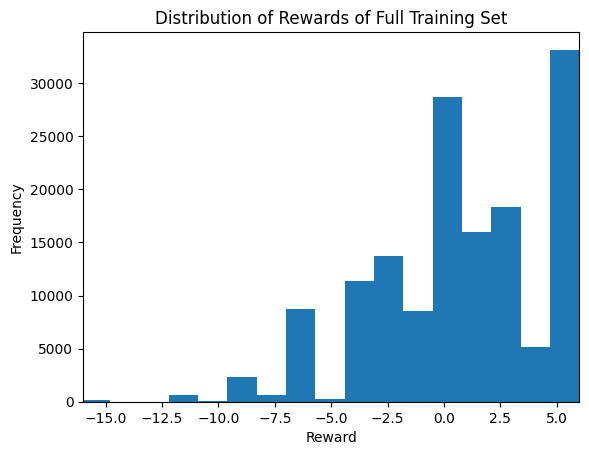

In [48]:
plt.hist(df_rewards['reward'], bins=30);
plt.xlabel('Reward');
plt.ylabel('Frequency');
plt.title('Distribution of Rewards of Full Training Set');
plt.xlim(-16,6);

# Training Reward Model

In [19]:
class RewardDataset(Dataset):
    def __init__(self, df: pd.DataFrame):
        # expect columns: "prompt", "response", "reward"
        self.df = df.reset_index(drop=True)

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        prompt = row["prompt"]
        response = row["response"]
        reward = torch.tensor(row["reward"], dtype=torch.float)

        return {
            "prompt": prompt,
            "response": response,
            "reward": reward,
        }


trn_df, val_df = train_test_split(
    df_rewards,
    test_size=0.2,
    random_state=39,
)

batch_size = 32

train_dataset = RewardDataset(trn_df)
train_loader = DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
)


val_dataset = RewardDataset(val_df)
val_loader = DataLoader(
    val_dataset,
    batch_size=batch_size,
    shuffle=True,
)




In [20]:
BASE_MODEL_NAME = "EleutherAI/pythia-70m"  # or your checkpoint
tokenizer = AutoTokenizer.from_pretrained(BASE_MODEL_NAME)

lora_r = 64

# make sure we have a pad token
if tokenizer.pad_token is None:
    tokenizer.pad_token = tokenizer.eos_token


class PythiaRewardModel(nn.Module):
    def __init__(
        self,
        base_model_name: str = BASE_MODEL_NAME,
        freeze_backbone: bool = True,
        use_lora: bool = True,
        lora_r: int = lora_r,
        lora_alpha: int = lora_r,
        lora_dropout: float = 0.05,
    ):
        super().__init__()

        # 1. Load base Pythia model
        self.transformer = AutoModel.from_pretrained(base_model_name)

        # 2. Optionally wrap with LoRA
        if use_lora:
            lora_config = LoraConfig(
                r=lora_r,
                lora_alpha=lora_alpha,
                lora_dropout=lora_dropout,
                bias="none",
                task_type=TaskType.FEATURE_EXTRACTION,
                # for Pythia / GPT-NeoX, this hits the attention qkv projection
                target_modules=["query_key_value"],
            )
            self.transformer = get_peft_model(self.transformer, lora_config)

        hidden_size = self.transformer.config.hidden_size

        # 3. Simple linear reward head: [B, H] -> [B, 1]
        self.reward_head = nn.Linear(hidden_size, 1)

        # 4. Optionally freeze backbone (but NOT LoRA + reward head)
        if freeze_backbone:
            for name, param in self.transformer.named_parameters():
                if use_lora:
                    # keep LoRA params trainable
                    if "lora_" in name:
                        param.requires_grad = True
                    else:
                        param.requires_grad = False
                else:
                    # no LoRA: freeze entire backbone
                    param.requires_grad = False

        # always train reward head
        for p in self.reward_head.parameters():
            p.requires_grad = True

    def encode(self, prompts, responses, device):
        """
        prompts, responses: lists of strings of equal length
        returns tokenized batch on `device`
        """

        # simplest: prompt + eos + response
        texts = [
            "PROMPT: " + p + tokenizer.eos_token + "RESPONSE: " + r
            for p, r in zip(prompts, responses)
        ]

        batch = tokenizer(
            texts,
            return_tensors="pt",
            padding=True,
            truncation=True,
        )
        return {k: v.to(device) for k, v in batch.items()}

    def forward(self, input_ids, attention_mask):
        # get hidden states from Pythia (via PEFT-wrapped model)
        outputs = self.transformer(
            input_ids=input_ids,
            attention_mask=attention_mask,
            #output_hidden_states=True,  # last_hidden_state is enough
        )
        #print(outputs.logits.shape)
        hidden_states = outputs.last_hidden_state  # [B, T, H]

        # index of last non-pad token for each example
        last_indices = attention_mask.sum(dim=1) - 1  # [B]
        batch_indices = torch.arange(
            hidden_states.size(0), device=hidden_states.device
        )

        h_last = hidden_states[batch_indices, last_indices]  # [B, H]

        rewards = self.reward_head(h_last).squeeze(-1)  # [B]
        return rewards


In [21]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = PythiaRewardModel(use_lora=True).to(device)
lr = 1e-4
optimizer = torch.optim.AdamW(model.parameters(), lr=lr)

num_epochs = 9

batch_trn_loss = []
batch_val_loss = []

for epoch in range(num_epochs):
    print(f"\n==== Epoch {epoch+1}/{num_epochs} ====")

    ###########################################
    # TRAINING PHASE
    ###########################################
    model.train()
    pbar = tqdm(train_loader, desc="Training", leave=True)
    running_loss = 0.0

    for samples in pbar:
        batch = model.encode(samples['prompt'], samples['response'], device)
        targets = samples['reward'].float().to(device)

        pred = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"]
        )

        loss = F.mse_loss(pred, targets)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

        pbar.set_postfix({
            "loss": f"{loss.item():.4f}",
            "avg": f"{running_loss / (pbar.n + 1):.4f}"
        })

        batch_trn_loss.append(loss.item())

        if (pbar.n % 1000 == 0):
            torch.save(model.state_dict(), f'/content/drive/My Drive/10-703/rm_model_lora_{lora_r}_lr_{lr}.pth')
            with open(f'/content/drive/My Drive/10-703/trn_data_hist_lora_{lora_r}_lr_{lr}.pkl', 'wb') as file:
                pickle.dump(batch_trn_loss, file)


    ###########################################
    # VALIDATION PHASE
    ###########################################
    model.eval()
    val_loss = 0.0
    num_batches = 0

    with torch.no_grad():
        val_pbar = tqdm(val_loader, desc="Validation", leave=True)

        for samples in val_pbar:
            batch = model.encode(samples['prompt'], samples['response'], device)
            targets = samples['reward'].float().to(device)

            pred = model(
                input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"]
            )

            loss = F.mse_loss(pred, targets)

            val_loss += loss.item()
            num_batches += 1

            val_pbar.set_postfix({
                "val_loss": f"{loss.item():.4f}"
            })

    avg_val_loss = val_loss / num_batches
    batch_val_loss.append(avg_val_loss)
    print(f"Epoch {epoch+1} validation loss: {avg_val_loss:.4f}")



==== Epoch 1/9 ====


Validation: 100%|██████████| 924/924 [00:43<00:00, 21.24it/s, val_loss=14.9185]


Epoch 1 validation loss: 14.9185

==== Epoch 2/9 ====


Validation: 100%|██████████| 924/924 [00:49<00:00, 18.84it/s, val_loss=11.9593]


Epoch 2 validation loss: 11.9593

==== Epoch 3/9 ====


Validation: 100%|██████████| 924/924 [00:35<00:00, 26.33it/s, val_loss=11.5952]


Epoch 3 validation loss: 11.5952

==== Epoch 4/9 ====


Validation: 100%|██████████| 924/924 [00:39<00:00, 23.62it/s, val_loss=14.9565]


Epoch 4 validation loss: 14.9565

==== Epoch 5/9 ====


Validation: 100%|██████████| 924/924 [00:51<00:00, 17.87it/s, val_loss=14.1757]


Epoch 5 validation loss: 14.1757

==== Epoch 6/9 ====


Validation: 100%|██████████| 924/924 [00:38<00:00, 24.22it/s, val_loss=9.6065]


Epoch 6 validation loss: 9.6065

==== Epoch 7/9 ====


Validation: 100%|██████████| 924/924 [00:38<00:00, 24.10it/s, val_loss=8.7115]


Epoch 7 validation loss: 8.7115

==== Epoch 8/9 ====


Validation: 100%|██████████| 924/924 [01:01<00:00, 14.95it/s, val_loss=7.4688]


Epoch 8 validation loss: 7.4688

==== Epoch 9/9 ====


Validation: 100%|██████████| 924/924 [00:48<00:00, 18.97it/s, val_loss=8.3162]

Epoch 9 validation loss: 8.3162


In [31]:
moving_avg_trn_loss = []
for i in range(100, len(batch_trn_loss)):
    moving_avg_trn_loss.append(sum(batch_trn_loss[i-100:i])/(100))

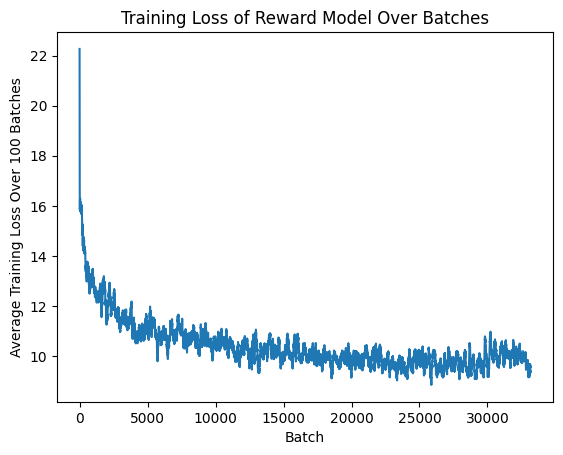

In [37]:
plt.plot(moving_avg_trn_loss);
plt.xlabel('Batch');
plt.ylabel('Average Training Loss Over 100 Batches');
plt.title('Training Loss of Reward Model Over Batches');

# Testing Reward Model

In [179]:
test_df = ds['test'].to_pandas()
test_df = convert_to_features(test_df)
test_df_melted = pd.DataFrame({
    "prompt": pd.concat([test_df["prompt"], test_df["prompt"]]),
    "response": pd.concat([test_df["response_0"], test_df["response_1"]]),
    "reward": pd.concat([test_df["reward_0"], test_df["reward_1"]]),
}).reset_index(drop=True)

In [180]:
test_dataset = RewardDataset(test_df_melted)
test_loader = DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
)

model.eval()
test_loss = 0.0
num_batches = 0

model_reward_output = np.array([])

with torch.no_grad():
    test_pbar = tqdm(test_loader, desc="Test", leave=True)

    for samples in test_pbar:
        batch = model.encode(samples['prompt'], samples['response'], device)
        targets = samples['reward'].float().to(device)

        pred = model(
            input_ids=batch["input_ids"],
            attention_mask=batch["attention_mask"]
        )

        model_reward_output = np.concatenate((model_reward_output, pred.cpu().numpy()))

        loss = F.mse_loss(pred, targets)

        test_loss += loss.item()
        num_batches += 1

        test_pbar.set_postfix({
            "test_loss": f"{loss.item():.4f}"
        })

avg_test_loss = test_loss / num_batches
print(f"test loss: {avg_test_loss:.4f}")

Test: 100%|██████████| 514/514 [01:49<00:00,  4.70it/s, test_loss=13.1394]

test loss: 9.8078


In [181]:
test_df_melted['pred_reward'] = model_reward_output

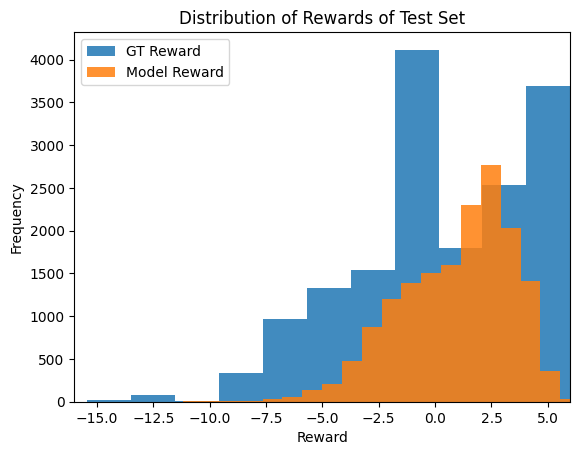

In [182]:
import seaborn as sns
plt.hist(test_df_melted['reward'], bins=20, label='GT Reward', alpha=0.85);
#sns.kdeplot(test_df_melted['reward'], fill=True, label='GT Reward', bw_adjust=1.0)
#sns.kdeplot(test_df_melted['pred_reward'], fill=True, label='Model Reward', bw_adjust=1)
plt.hist(test_df_melted['pred_reward'], bins=20, label='Model Reward', alpha=0.85);
plt.xlabel('Reward');
plt.ylabel('Frequency');
plt.title('Distribution of Rewards of Test Set');
plt.xlim(-16,6);
plt.legend();

# Analysis of Reward Model Outputs on Test Set

In [185]:
test_df_melted['severity'] = np.concatenate([ds['test'].to_pandas()['response_0_severity_level'], ds['test'].to_pandas()['response_1_severity_level']])

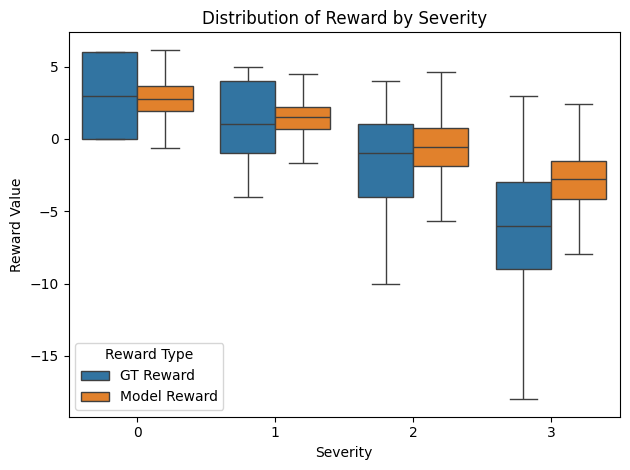

In [186]:
test_df_melted_temp = test_df_melted.melt(id_vars=["severity"], value_vars=["reward", "pred_reward"],
                                          var_name="reward_type", value_name="reward_value")
ax = sns.boxplot(data=test_df_melted_temp, x="severity",
            y="reward_value", hue="reward_type", showfliers=False)

plt.title("Distribution of Reward by Severity")
plt.xlabel("Severity")
plt.ylabel("Reward Value")

handles, labels = ax.get_legend_handles_labels()
new_labels = ["GT Reward", "Model Reward"]
plt.legend(handles, new_labels, title="Reward Type")

plt.tight_layout()
plt.show()

del test_df_melted_temp

In [187]:
test = ds['test'].to_pandas()

In [188]:
test_df_melted['n_harms'] = np.concatenate([test['response_0_harm_category'].apply(lambda x: sum(x.values())), test['response_1_harm_category'].apply(lambda x: sum(x.values()))])

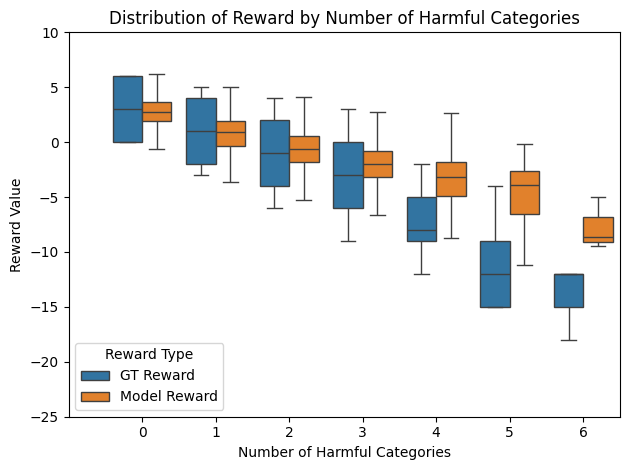

In [189]:
test_df_melted_temp = test_df_melted.melt(id_vars=["n_harms"], value_vars=["reward", "pred_reward"],
                                          var_name="reward_type", value_name="reward_value")
ax = sns.boxplot(data=test_df_melted_temp, x="n_harms",
            y="reward_value", hue="reward_type", showfliers=False)

plt.title("Distribution of Reward by Number of Harmful Categories")
plt.xlabel("Number of Harmful Categories")
plt.ylabel("Reward Value")

handles, labels = ax.get_legend_handles_labels()
new_labels = ["GT Reward", "Model Reward"]
plt.legend(handles, new_labels, title="Reward Type", loc="lower left")

plt.tight_layout()
plt.xlim(-1, 6.5)
plt.ylim(-25, 10)
plt.show()

del test_df_melted_temp

In [190]:
better_responses_0 = []
better_responses_1 = []
for i in test['better_response_id']:
    if i == 0:
        better_responses_0.append(1)
        better_responses_1.append(0)
    else:
        better_responses_0.append(0)
        better_responses_1.append(1)
test_df_melted['better_response'] = np.concatenate([better_responses_0, better_responses_1])

In [191]:
safer_responses_0 = []
safer_responses_1 = []
for i in test['safer_response_id']:
    if i == 0:
        safer_responses_0.append(1)
        safer_responses_1.append(0)
    else:
        safer_responses_0.append(0)
        safer_responses_1.append(1)
test_df_melted['safer_response'] = np.concatenate([safer_responses_0, safer_responses_1])

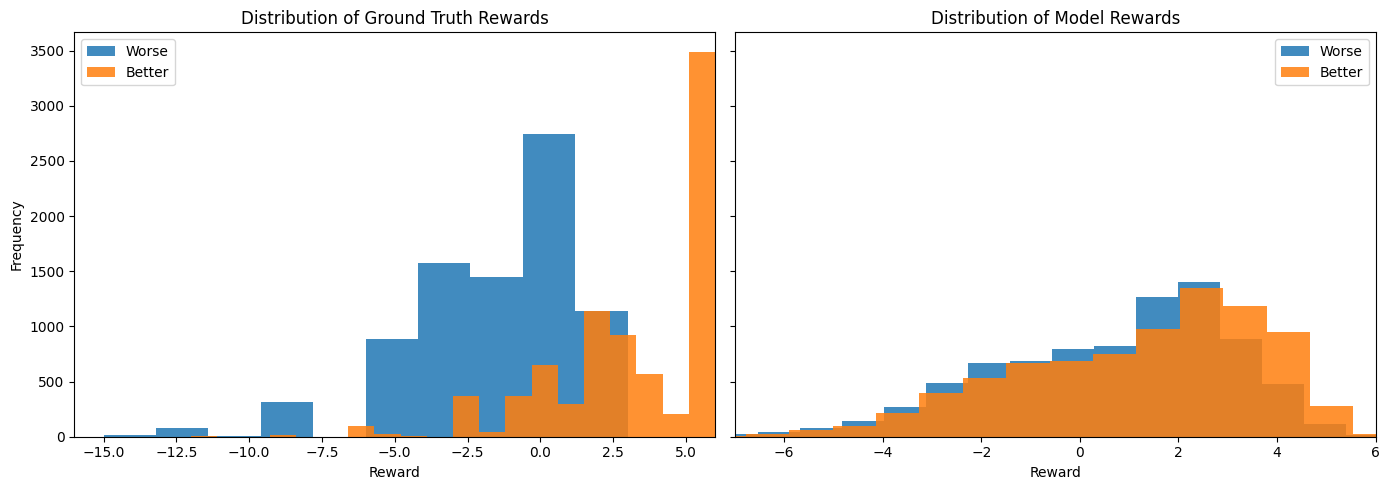

In [197]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# -------- LEFT: Ground Truth Rewards --------
axes[0].hist(
    test_df_melted[test_df_melted['better_response'] == 0]['reward'],
    bins=20, label='Worse', alpha=0.85
)
axes[0].hist(
    test_df_melted[test_df_melted['better_response'] == 1]['reward'],
    bins=20, label='Better', alpha=0.85
)
axes[0].set_xlabel('Reward')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Ground Truth Rewards')
axes[0].set_xlim(-16, 6)
axes[0].legend()

# -------- RIGHT: Model Rewards --------
axes[1].hist(
    test_df_melted[test_df_melted['better_response'] == 0]['pred_reward'],
    bins=20, label='Worse', alpha=0.85
)
axes[1].hist(
    test_df_melted[test_df_melted['better_response'] == 1]['pred_reward'],
    bins=20, label='Better', alpha=0.85
)
axes[1].set_xlabel('Reward')
axes[1].set_title('Distribution of Model Rewards')
axes[1].set_xlim(-7, 6)
axes[1].legend()

plt.tight_layout()
plt.show()


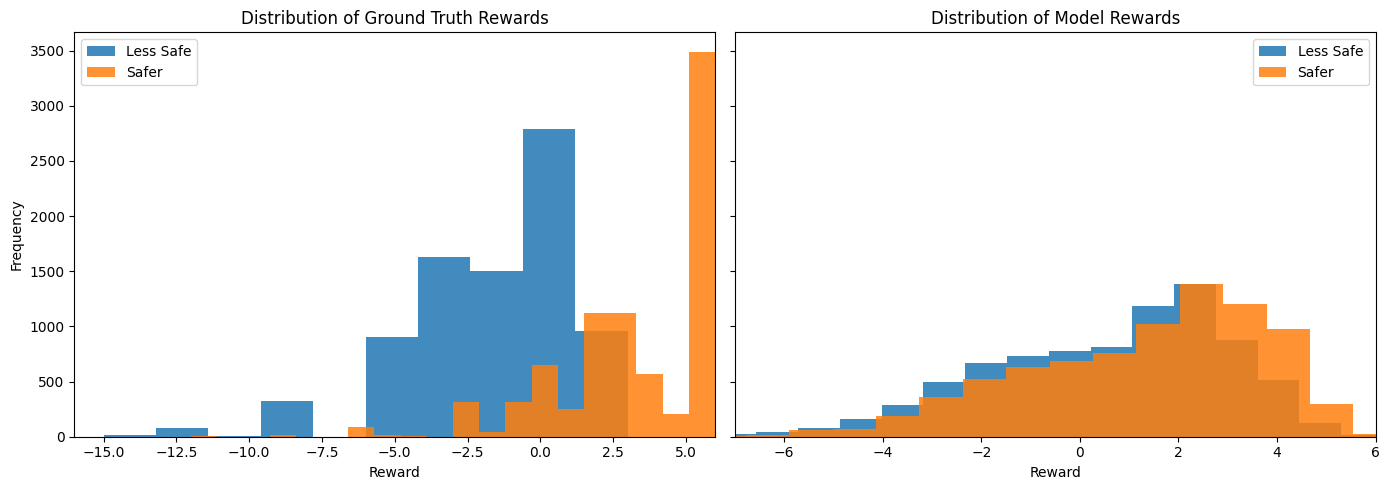

In [196]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 2, figsize=(14, 5), sharey=True)

# -------- LEFT: Ground Truth Rewards --------
axes[0].hist(
    test_df_melted[test_df_melted['safer_response'] == 0]['reward'],
    bins=20, label='Less Safe', alpha=0.85
)
axes[0].hist(
    test_df_melted[test_df_melted['safer_response'] == 1]['reward'],
    bins=20, label='Safer', alpha=0.85
)
axes[0].set_xlabel('Reward')
axes[0].set_ylabel('Frequency')
axes[0].set_title('Distribution of Ground Truth Rewards')
axes[0].set_xlim(-16, 6)
axes[0].legend()

# -------- RIGHT: Model Rewards --------
axes[1].hist(
    test_df_melted[test_df_melted['safer_response'] == 0]['pred_reward'],
    bins=20, label='Less Safe', alpha=0.85
)
axes[1].hist(
    test_df_melted[test_df_melted['safer_response'] == 1]['pred_reward'],
    bins=20, label='Safer', alpha=0.85
)
axes[1].set_xlabel('Reward')
axes[1].set_title('Distribution of Model Rewards')
axes[1].set_xlim(-7, 6)
axes[1].legend()

plt.tight_layout()
plt.show()
